# Training Lifecycle

This tutorial demonstrates the complete training workflow in Myriad:
1. **Baselines**: Evaluate non-learning controllers for comparison
2. **Training**: Train a DQN agent with checkpointed evaluations
3. **Visualization**: Plot learning curves and render policy evolution
4. **Inspection**: Explore metrics, agent state, and training history
5. **Persistence**: Save and load runs for reproducibility

We'll use the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) balancing task — the pole starts upright and the agent must keep it balanced by pushing the cart left or right. An episode ends when the pole falls past a threshold angle or the cart leaves the track.

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt

from myriad import (
    config_to_eval_config,
    create_config,
    create_eval_config,
    evaluate,
    load_run,
    train_and_evaluate,
)
from myriad.utils.rendering import render_episodes
from myriad.utils.plotting import plot_training_curve

from _helpers import side_by_side_videos

## Baselines

Before training, we establish baseline performance using the **evaluation API** from Tutorial 01.

We test two non-learning controllers:
- **Random**: provides a lower bound on performance
- **Bang-Bang**: switches on `theta_dot` (angular velocity), pushing in the direction the pole is falling

The bang-bang strategy keeps the pole upright but ignores cart position, so the cart drifts off the track, limiting performance to ~185 out of a possible 500. DQN will need to learn both pole balancing AND cart position control to reach 500.

In [2]:
baselines = {
    "Random": dict(agent="random"),
    "Bang-Bang": dict(agent="bangbang", obs_field="theta_dot", threshold=0.0),
}

baseline_results = {}
baseline_episodes = {}
for label, kwargs in baselines.items():
    config = create_eval_config(env="cartpole-control", eval_rollouts=50, seed=0, **kwargs)
    results = evaluate(config, return_episodes=True)
    baseline_results[label] = results
    baseline_episodes[label] = results.episodes
    print(f"{label}: {results}\n")

Random: EvaluationResults(
  mean_return=22.1 ± 10.9,
  range=[10.0, 57.0],
  mean_length=22.1,
  num_episodes=50
)

Bang-Bang: EvaluationResults(
  mean_return=184.5 ± 39.0,
  range=[131.0, 268.0],
  mean_length=184.5,
  num_episodes=50
)



## Train DQN

Now we switch to the **training API**: `create_config()` + `train_and_evaluate()`.

The training config includes everything from the evaluation API (environment, agent, seed) plus:
- **Optimization**: batch size, buffer size, learning rate
- **Checkpointing**: evaluation frequency, episode saving
- **Training loop**: number of environments, steps per environment

`train_and_evaluate()` returns a `TrainingResults` object containing:
- Trained agent state (network weights, optimizer state)
- Training metrics (loss, reward over time)
- Evaluation metrics at each checkpoint (mean return, episode lengths)
- The full configuration used

We enable episode saving to visualize how the policy evolves during training.

**Key settings:**
- **128 parallel environments** for fast, stable gradient estimates
- **5,000 steps per env** — total of 640K transitions, enough for DQN convergence
- **`epsilon_decay_steps=2000`** — linear ε-greedy decay from 1.0 → 0.1 over first 40% of training
- **`scan_chunk_size=500`** — must be ≤ `eval_frequency` to avoid wasted computation (see [JAX scan docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html))
- **Episode saving** — saves one episode per eval checkpoint for later visualization

In [3]:
config = create_config(
    env="cartpole-control",
    agent="dqn",
    num_envs=128,
    steps_per_env=5000,
    eval_frequency=500,
    log_frequency=500,
    eval_rollouts=50,
    seed=0,
    epsilon_decay_steps=2000,
    target_network_frequency=100,
    scan_chunk_size=500,
    # Enable episode saving
    eval_episode_save_frequency=500,
    eval_episode_save_count=1,
)
results = train_and_evaluate(config)
print(results)

# Get run directory for later use
run_dir = sorted(Path("outputs").glob("*/*/"))[-1]
print(f"\nRun saved to: {run_dir}")

Training: 100%|██████████| 5000/5000 [00:01<00:00, 3243.98steps/s] , loss=0.064, eval_return=500.00

TrainingResults(
  final_eval_return=500.0 ± 0.0,
  steps_per_env=5,000,
  global_steps=640,000,
  num_evals=10
)

Run saved to: outputs/2026-02-12/14-38-13


## Learning Curve

Plot DQN's mean return over training with baseline scores as horizontal reference lines.

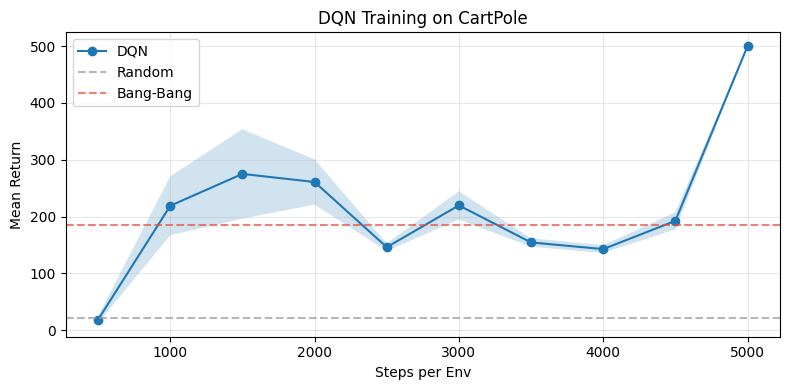

In [4]:
baselines = {label: res.mean_return for label, res in baseline_results.items()}
baseline_colors = {"Random": "#999", "Bang-Bang": "#e74c3c"}

fig, ax = plot_training_curve(
    results,
    title="DQN Training on CartPole",
)

# Add baseline reference lines
for label, value in baselines.items():
    color = baseline_colors.get(label, "#666")
    ax.axhline(y=value, linestyle="--", color=color, alpha=0.7, label=label)

ax.legend()
plt.show()

## Visualize Learning Progress

Create two video comparisons:
1. **DQN learning progression**: How the policy evolves from early (500 steps) to mid (2500 steps) to final (5000 steps)
2. **Final performance comparison**: Trained DQN vs Bang-Bang baseline

In [5]:
# === Video Set 1: DQN Learning Progression ===
steps_labels = [(500, "Early"), (2500, "Mid"), (5000, "Final")]

# Generate and save videos
video_paths, episode_data = render_episodes(
    run_dir=run_dir,
    step=[s for s, _ in steps_labels],
    output_path=run_dir / "videos",
    fps=50,
)

# Create labels with return information
video_labels = []
for (step, label), meta in zip(steps_labels, episode_data):
    episode_return = float(meta["episode_return"])
    video_labels.append(f"{label} ({step} steps)\nReturn: {episode_return:.0f}")

side_by_side_videos(video_paths, video_labels, width=300)

In [6]:
# === Video Set 2: Final Performance Comparison ===
comparison_paths, comparison_labels = [], []

# Bang-Bang baseline - render from EvaluationResults
path, meta = render_episodes(
    results=baseline_results["Bang-Bang"],
    episode_index=0,
    env_name="cartpole-control",  # Required since evaluate() results don't have config
    output_path="videos/cartpole_bangbang.mp4",
    fps=50
)
comparison_paths.append(path)
comparison_labels.append(f"Bang-Bang\nReturn: {meta['episode_return']:.0f}")

# Trained DQN - render from disk (final checkpoint)
final_step = steps_labels[-1][0]
path, meta = render_episodes(
    run_dir=run_dir,
    step=final_step,
    output_path="videos/cartpole_dqn.mp4",
    fps=50
)
comparison_paths.append(path)
comparison_labels.append(f"DQN (trained)\nReturn: {meta['episode_return']:.0f}")

side_by_side_videos(comparison_paths, comparison_labels)

## Inspect Results

The `TrainingResults` object bundles everything from the run:
- **`agent_state`**: Trained network weights and optimizer state
- **`training_metrics`**: Loss, reward, and agent-specific metrics (Q-values, TD error) over time
- **`eval_metrics`**: Evaluation results at each checkpoint (returns, lengths)
- **`config`**: The exact configuration used for this run
- **`final_env_state`**: Environment state at training end

Let's explore the available data:

In [7]:
# Summary dict of key metrics
print("Summary:")
print(results.summary())

# All available result fields
print("\nAvailable fields:")
print("Training metrics: ", list(results.training_metrics.__dict__.keys()))
print("Evaluation metrics: ", list(results.eval_metrics.__dict__.keys()))
print("Agent state: ", list(results.agent_state.__dict__.keys()))
print("Final environment state: ", list(results.final_env_state.__dict__.keys()))
print("Run configuration: ", results.config)

Summary:
{'final_eval_return_mean': 500.0, 'final_eval_return_std': 0.0, 'training_steps_per_env': 5000, 'training_global_steps': 640000, 'num_eval_checkpoints': 10}

Available fields:
Training metrics:  ['global_steps', 'steps_per_env', 'loss', 'reward', 'agent_metrics']
Evaluation metrics:  ['global_steps', 'steps_per_env', 'episode_returns', 'episode_lengths', 'mean_return', 'std_return', 'mean_length']
Agent state:  ['train_state', 'target_params', 'global_step']
Final environment state:  ['env_state', 'obs']
Run configuration:  run=RunConfig(seed=0, eval_rollouts=50, eval_max_steps=500, eval_episode_save_frequency=500, eval_episode_save_count=1, eval_render_videos=False, eval_video_fps=50, save_agent_checkpoint=False, steps_per_env=5000, num_envs=128, scan_chunk_size=500, buffer_size=10000, rollout_steps=None, eval_frequency=500, log_frequency=500) agent=AgentConfig(name='dqn', batch_size=32, epsilon_decay_steps=2000, target_network_frequency=100) env=EnvConfig(name='cartpole-cont

In [8]:
# Mean return at each eval checkpoint
print("Eval steps:", results.eval_metrics.steps_per_env)
print("Mean return:", results.eval_metrics.mean_return)

# Raw episode returns from the 3rd checkpoint
print(f"\nThird checkpoint ({len(results.eval_metrics.episode_returns[2])} episodes):")
print(results.eval_metrics.episode_returns[2])

Eval steps: [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
Mean return: [18.760000228881836, 219.0800018310547, 275.1400146484375, 260.8599853515625, 146.13999938964844, 219.72000122070312, 154.47999572753906, 142.75999450683594, 192.5399932861328, 500.0]

Third checkpoint (50 episodes):
[273. 244. 275. 219. 222. 233. 227. 252. 206. 489. 228. 200. 311. 198.
 239. 207. 231. 378. 251. 500. 244. 337. 330. 263. 223. 215. 194. 477.
 200. 396. 211. 258. 306. 237. 203. 280. 215. 249. 271. 327. 321. 245.
 234. 278. 500. 274. 221. 333. 257. 275.]


In [9]:
# Training loss history
print("# of loss checkpoints:", len(results.training_metrics.loss))
print("Final loss:", f"{results.training_metrics.loss[-1]:.4f}")

# Examples of additional agent-specific metrics
print("\nAgent-specific metrics:")
print("Final DQN Q value: ", results.training_metrics.agent_metrics["q_value"][-1])
print("Final DQN TD error: ", results.training_metrics.agent_metrics["td_error"][-1])

# of loss checkpoints: 10
Final loss: 0.0637

Agent-specific metrics:
Final DQN Q value:  41.415489196777344
Final DQN TD error:  0.20919108390808105


## Re-evaluate Trained Agent

We can evaluate the trained agent using `evaluate()` — the same function used for non-learning controllers.

The `config_to_eval_config()` helper converts a training config to an evaluation config, preserving environment and agent settings while removing training-specific parameters. We pass the trained `agent_state` to evaluate using the learned policy instead of random initialization.

In [10]:
# Evaluate trained DQN
eval_config = config_to_eval_config(results.config)
dqn_eval = evaluate(eval_config, agent_state=results.agent_state)
print("Trained DQN:", dqn_eval)

# Bang-bang baseline for comparison
bangbang_config = create_eval_config(
    env="cartpole-control",
    agent="bangbang",
    obs_field="theta",
    eval_rollouts=eval_config.run.eval_rollouts,
    seed=0,
)
bangbang_eval = evaluate(bangbang_config)
print("\nBang-bang baseline:", bangbang_eval)

Trained DQN: EvaluationResults(
  mean_return=500.0 ± 0.0,
  range=[500.0, 500.0],
  mean_length=500.0,
  num_episodes=50
)

Bang-bang baseline: EvaluationResults(
  mean_return=40.1 ± 6.9,
  range=[25.0, 59.0],
  mean_length=40.1,
  num_episodes=50
)


## Artifact Saving

Artifacts are automatically saved when you call `train_and_evaluate()`. The run directory is determined automatically:
- Under Hydra (when using scripts): Uses Hydra's output directory
- In notebooks/scripts: Creates timestamped directory in `outputs/`

You can also manually save results later using `results.save()`:

In [11]:
# Artifacts were already auto-saved during training
# But you can also explicitly save results to a different directory if needed
alternate_dir = Path("alternate_save")
results.save(alternate_dir)

print("Saved artifacts to alternate location:")
for p in sorted(alternate_dir.rglob("*")):
    if p.is_file():
        print(f"  {str(p):35s} {p.stat().st_size:>8,} bytes")

# Clean up the alternate directory
shutil.rmtree(alternate_dir)

Saved artifacts to alternate location:
  alternate_save/.hydra/config.yaml        619 bytes
  alternate_save/results.pkl             6,478 bytes


## Load Saved Runs

The `load_run()` API loads all artifacts from a run directory in one call:

In [12]:
# Load all artifacts from the run directory
loaded_run = load_run(run_dir)

print("Loaded run:")
print(f"  Config type: {type(loaded_run.config).__name__}")
print(f"  Results type: {type(loaded_run.results).__name__}")
print(f"  Final return: {loaded_run.results.summary()['final_eval_return_mean']:.1f}")
print(f"  Training steps: {loaded_run.results.summary()['training_steps_per_env']:,}")

# Verify results match
assert loaded_run.results.summary() == results.summary()
print("\n✓ Loaded results match original")

Loaded run:
  Config type: Config
  Results type: TrainingResults
  Final return: 500.0
  Training steps: 5,000

✓ Loaded results match original


## Reproduce from Loaded Config

Use the loaded config to reproduce the exact same run. JAX's functional paradigm guarantees determinism — same config and seed produces identical results.

In [13]:
# Retrain using the loaded config
reproduced = train_and_evaluate(loaded_run.config)

print("Original returns: ", results.eval_metrics.mean_return)
print("Reproduced returns:", reproduced.eval_metrics.mean_return)
assert results.eval_metrics.mean_return == reproduced.eval_metrics.mean_return
print("\n✓ Identical. Same seed guarantees reproducibility.")

Training: 100%|██████████| 5000/5000 [00:01<00:00, 3297.98steps/s] , loss=0.064, eval_return=500.00

Original returns:  [18.760000228881836, 219.0800018310547, 275.1400146484375, 260.8599853515625, 146.13999938964844, 219.72000122070312, 154.47999572753906, 142.75999450683594, 192.5399932861328, 500.0]
Reproduced returns: [18.760000228881836, 219.0800018310547, 275.1400146484375, 260.8599853515625, 146.13999938964844, 219.72000122070312, 154.47999572753906, 142.75999450683594, 192.5399932861328, 500.0]

✓ Identical. Same seed guarantees reproducibility.


## Seed Reproducibility

Different seeds produce different training trajectories, but the same seed always reproduces exactly:

In [14]:
# Train with a different seed
config_seed1 = create_config(
    env="cartpole-control",
    agent="dqn",
    num_envs=128,
    steps_per_env=5000,
    eval_frequency=500,
    log_frequency=500,
    eval_rollouts=50,
    seed=1,  # Different seed
    epsilon_decay_steps=2000,
    target_network_frequency=100,
    scan_chunk_size=500,
)
results_seed1 = train_and_evaluate(config_seed1)

print("Seed 0 final return:", results.eval_metrics.mean_return[-1])
print("Seed 1 final return:", results_seed1.eval_metrics.mean_return[-1])
print("\n✓ Different seeds produce different trajectories (but both converge).")

Training: 100%|██████████| 5000/5000 [00:01<00:00, 3077.51steps/s] , loss=0.362, eval_return=137.52

Seed 0 final return: 500.0
Seed 1 final return: 137.52000427246094

✓ Different seeds produce different trajectories (but both converge).


## Cleanup

In [15]:
# Clean up the auto-created run directory
shutil.rmtree(run_dir)